In [13]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import time
from model_layers import get_CNN_model

# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/tirth/projects/college/DATA-298-MSDAProject/project/Model Training & Evaluation/__helpers')

import evaluation
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [14]:
batch_size = 64
num_epoch = 500
num_class = 5

In [15]:

def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history['history']['accuracy'])+1),model_history['history']['accuracy'])
    axs[0].plot(range(1,len(model_history['history']['val_accuracy'])+1),model_history['history']['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history['history']['accuracy'])+1, 3))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history['history']['loss'])+1),model_history['history']['loss'])
    axs[1].plot(range(1,len(model_history['history']['val_loss'])+1),model_history['history']['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history['history']['loss'])+1, 3))
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()


In [16]:
def load_dataset(data_dir):
    X = []
    Y = []
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if not os.path.exists(file_path):
              print(file_path)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (96, 96))
            X.append(image)
            Y.append(category)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

train_images, train_labels = load_dataset('dataset/train')
test_images, test_labels = load_dataset('dataset/test')

# Normalize the images
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Convert class vectors to binary class matrices
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

train_labels = tf.keras.utils.to_categorical(train_labels, num_class)
test_labels = tf.keras.utils.to_categorical(test_labels, num_class)

# Split training dataset into training and validation dataset
validation_split = 0.2
indices = np.random.permutation(train_images.shape[0])
train_indices = indices[:int(train_images.shape[0] * (1 - validation_split))]
val_indices = indices[int(train_images.shape[0] * (1 - validation_split)):]

val_images, val_labels = train_images[val_indices], train_labels[val_indices]
train_images, train_labels = train_images[train_indices], train_labels[train_indices]

In [17]:
le.classes_

array(['back_right', 'buy_right', 'more_right', 'next_right',
       'previous_right'], dtype='<U14')

In [18]:
train_images[0].shape, val_images[0].shape

((96, 96, 3), (96, 96, 3))

In [19]:
def custom_loss(y_true, y_pred):
    # Define penalty
    penalty = 1

    # Compute cross-entropy loss
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Compute penalty for misclassifications
    pred_labels = tf.argmax(y_pred, axis=1)
    true_labels = tf.argmax(y_true, axis=1)
    incorrect_preds = tf.not_equal(pred_labels, true_labels)
    penalty_loss = tf.cast(incorrect_preds, tf.float32) * penalty

    # Compute total loss
    total_loss = ce_loss + penalty_loss

    return total_loss

In [20]:

# Create the model
model = get_CNN_model(num_class)
model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.00001, decay=1e-6),metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 46, 46, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                  

In [22]:
model_info = None
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
try:
  model.load_weights('model_CNN.h5')
except:
  start_time = time.time()
  model_info = model.fit(
            train_images,
            train_labels,
            epochs=num_epoch,
            batch_size=batch_size,
            callbacks=[early_stopping],
            validation_data=(val_images, val_labels))
  model.save_weights('model_CNN.h5')
  end_time = time.time()
  print('Training Time: ', end_time-start_time)
  np.save('history.npy', model_info.history)

Epoch 1/500
261/261 [==============================] - 14s 51ms/step - loss: 1.7744 - accuracy: 0.5060 - val_loss: 1.2471 - val_accuracy: 0.7613
Epoch 2/500
261/261 [==============================] - 13s 47ms/step - loss: 0.7999 - accuracy: 0.8075 - val_loss: 0.7097 - val_accuracy: 0.8668
Epoch 3/500
261/261 [==============================] - 12s 47ms/step - loss: 0.3822 - accuracy: 0.9242 - val_loss: 0.4556 - val_accuracy: 0.9040
Epoch 4/500
261/261 [==============================] - 12s 47ms/step - loss: 0.2054 - accuracy: 0.9643 - val_loss: 0.3789 - val_accuracy: 0.9045
Epoch 5/500
261/261 [==============================] - 12s 47ms/step - loss: 0.1271 - accuracy: 0.9809 - val_loss: 0.2905 - val_accuracy: 0.9191
Epoch 6/500
261/261 [==============================] - 12s 47ms/step - loss: 0.0809 - accuracy: 0.9895 - val_loss: 0.3071 - val_accuracy: 0.9232
Epoch 7/500
261/261 [==============================] - 12s 47ms/step - loss: 0.0631 - accuracy: 0.9915 - val_loss: 0.1910 - val_ac

In [23]:
start_time = time.time()
model.evaluate(test_images, test_labels)
end_time = time.time()
print('Evaluation Time: ', end_time-start_time)

80/80 [==============================] - 1s 14ms/step - loss: 3.7121 - accuracy: 0.7864
Evaluation Time:  1.3244948387145996


In [24]:
start_time = time.time()
Y_pred = model.predict(test_images)
end_time = time.time()
print(f'Testing Time for {len(test_images)} images: ', end_time-start_time)
y_pred = np.argmax(Y_pred, axis=1)

test_labels_t = np.argmax(test_labels, axis=1)

Testing Time for 2547 images:  1.0396263599395752


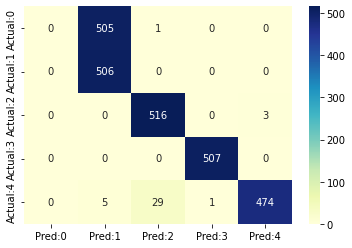

          Pred:0  Pred:1  Pred:2  Pred:3  Pred:4
Actual:0       0     505       1       0       0
Actual:1       0     506       0       0       0
Actual:2       0       0     516       0       3
Actual:3       0       0       0     507       0
Actual:4       0       5      29       1     474
                precision    recall  f1-score   support

    back_right       0.00      0.00      0.00         0
     buy_right       1.00      0.50      0.66      1016
    more_right       0.99      0.95      0.97       546
    next_right       1.00      1.00      1.00       508
previous_right       0.93      0.99      0.96       477

      accuracy                           0.79      2547
     macro avg       0.79      0.69      0.72      2547
  weighted avg       0.99      0.79      0.85      2547

Percent Back correctly predicted:  0.0
Percent Buy correctly predicted:  100.0
Percent More correctly predicted:  99.42196531791907
Percent Next correctly predicted:  100.0
Percent Previous correctly

/opt/homebrew/Caskroom/miniforge/base/envs/dev_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dev_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dev_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

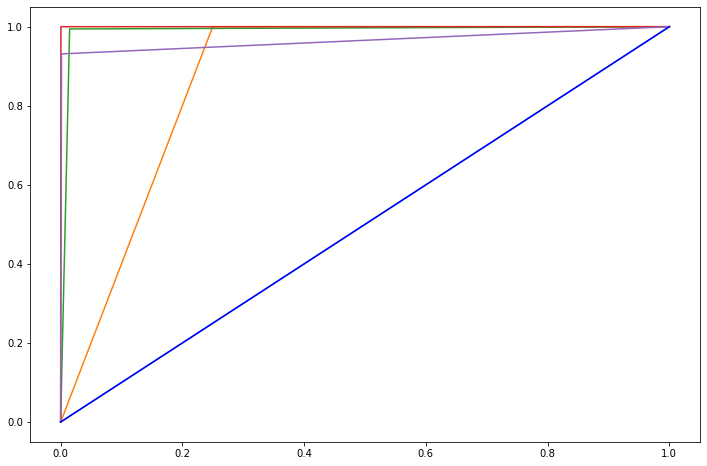

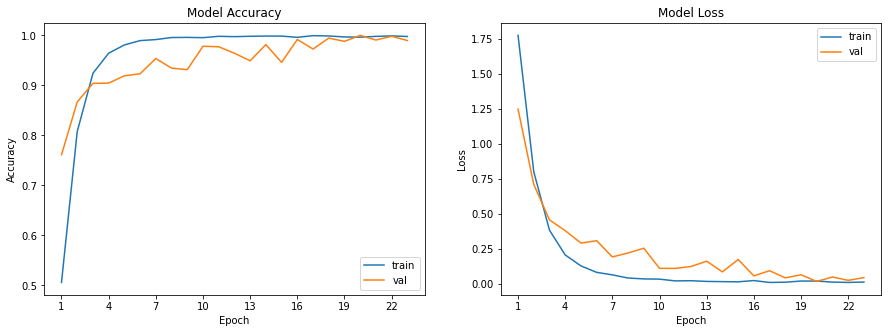

In [25]:
evaluation.print_performance(y_pred, test_labels_t)
evaluation.multiclass_roc_auc_score(test_labels_t, y_pred)

g = {}
model_info = { 'history': np.load('history.npy', allow_pickle=True).item() }

plot_model_history(model_info)